In [6]:
# suppress warnings
import warnings
warnings.simplefilter('ignore')
# import installed packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.insert(0,'/Users/Kathy/Desktop/UW/seaflow/decomposition_project/scripts/')
from rate_functions import *
from simulation_tools import *

## Generate data

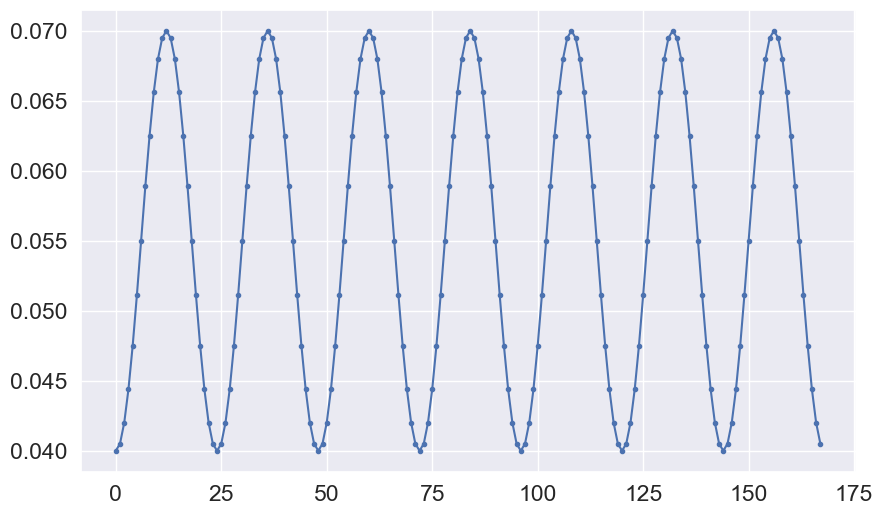

In [88]:
# generate simulation data with known periodicity of 24H, 10 full days
cycles = 8 # how many sine cycles
resolution = cycles*24 # how many datapoints to generate
# calculate length
length = np.pi * 2 * cycles
# set x with custom amplitude
x=np.arange(0, length, length / resolution)
# adjust amplitude and start/end
my_wave = 0.15*np.sin(x) + 0.55
start=np.where(my_wave == np.min(my_wave))[0][0]
end=np.where(my_wave == np.min(my_wave))[0][-1]-1
# crop wave
new_wave=my_wave[start:end+1]/10

# show simulation data
fig,axs=plt.subplots(figsize=(10,6))
axs.plot(new_wave, marker='.')

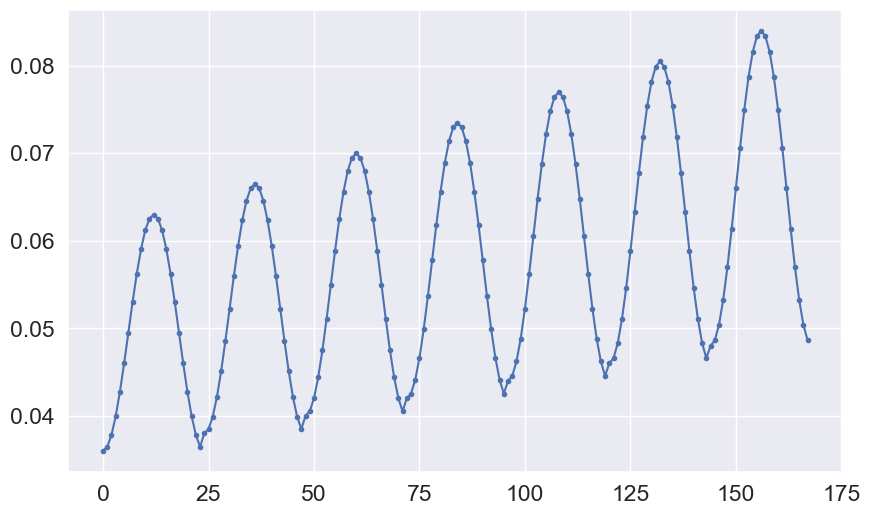

In [89]:
## scenario 2
## add trend
day_len=24
days=np.arange(0, len(new_wave), day_len)
trend=np.linspace(0.9, 1.2, 7)
data2=new_wave.copy()
# loop through eacy day
for day, m in zip(days, trend):
    data2[day:day+day_len]=data2[day:day+day_len]*m
# show simulation data
fig,axs=plt.subplots(figsize=(10,6))
axs.plot(data2, marker='.')

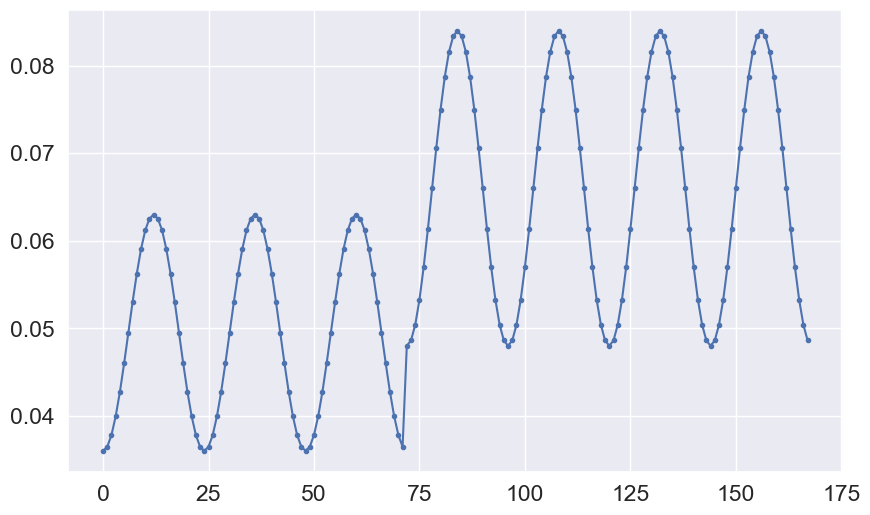

In [90]:
## scenario 3
data3=new_wave.copy()
# separate first 3 days
chunk1=new_wave[:day_len*3]*0.9
chunk2=new_wave[day_len*3:]*1.2
# concatenate
breaks=np.concatenate([chunk1,chunk2])

# # show simulation data
fig,axs=plt.subplots(figsize=(10,6))
axs.plot(breaks, marker='.')

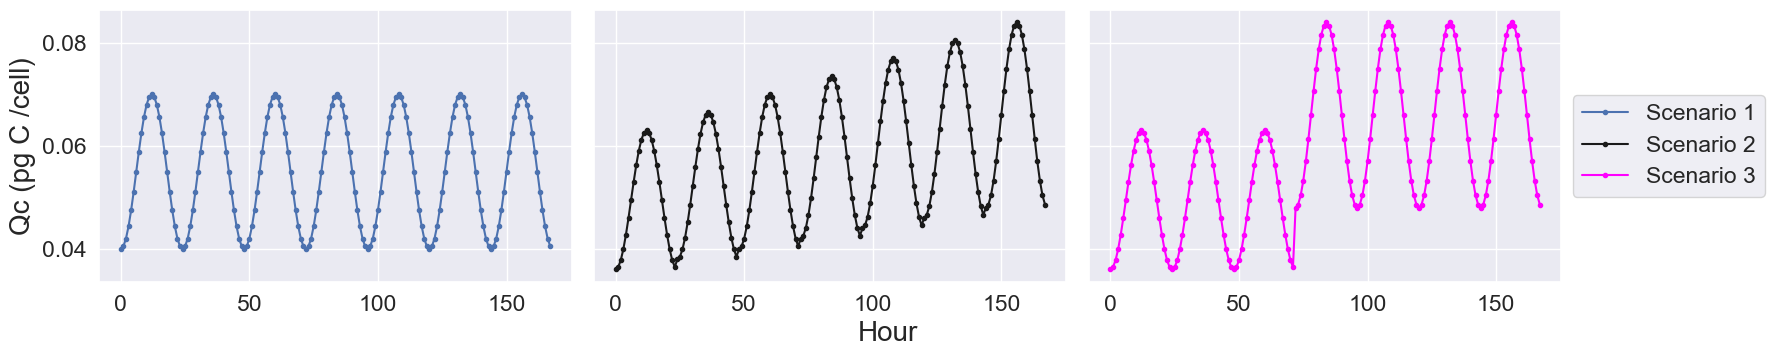

In [95]:
# show simulation data
fig,axs=plt.subplots(figsize=(18,3.5), ncols=3, sharey=True)
ln1=axs[0].plot(new_wave, marker='.', label='Scenario 1')
axs[0].set_ylabel('Qc (pg C /cell)', size=20)
ln2=axs[1].plot(data2, marker='.', c='k', label='Scenario 2')
ln3=axs[2].plot(breaks, marker='.', c='magenta', label='Scenario 3')
fig.text(0.5, -0.01, 'Hour', ha='center', size=20)
plt.rcParams.update({'font.size':15})
lns=ln1+ln2+ln3
labs = [l.get_label() for l in lns]
axs[2].legend(lns,labs,loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

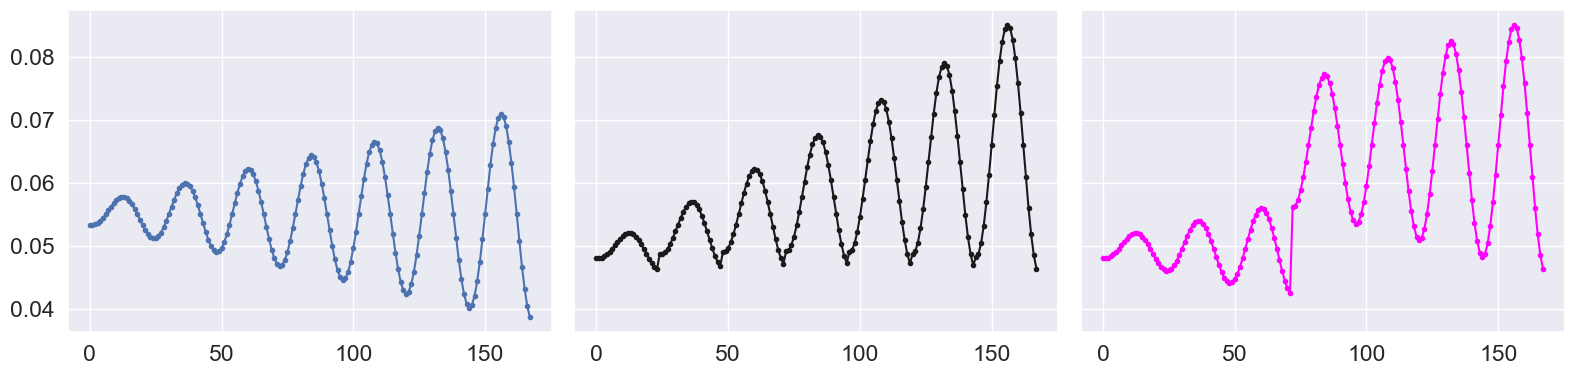

In [94]:
## now generate for changing amplitudes
## scenario 1
# generate simulation data with known periodicity of 24H, 10 full days
cycles = 8 # how many sine cycles
resolution = cycles*24 # how many datapoints to generate
# calculate length
length = np.pi * 2 * cycles
# set x with custom amplitude
x=np.arange(0, length, length / resolution)
# adjust amplitude and start/end
my_wave = np.sin(x)#*0.15 + 0.55
am_wave=my_wave*x*0.0035+0.55
start=np.where(my_wave == np.min(my_wave))[0][0]
end=np.where(my_wave == np.min(my_wave))[0][-1]-1
# crop wave
moving_wave=am_wave[start:end+1]/10


## scenario 2
day_len=24
moving_data2=moving_wave.copy()
# loop through eacy day
for day, m in zip(days, trend):
    moving_data2[day:day+day_len]=moving_data2[day:day+day_len]*m

plt.show()

## scenario 3
moving_data3=moving_wave.copy()
# separate first 3 days
chunk1=moving_wave[:day_len*3]*0.9
chunk2=moving_wave[day_len*3:]*1.2
# concatenate
moving_breaks=np.concatenate([chunk1,chunk2])

# # show simulation data
fig,axs=plt.subplots(figsize=(16,4),ncols=3,sharey=True)
axs[0].plot(moving_wave,marker='.')
axs[1].plot(moving_data2,marker='.',c='k')
axs[2].plot(moving_breaks, marker='.',c='magenta')
plt.tight_layout()
plt.show()

## calculate µ
- Annette's method: ln(QC)=r×t+ln(QC,0),

In [97]:
## deprecated helper function
def sr_hourly_growth(df, col, start):
    # get qc vals
    curr_qc=df[col]
    sr_qc=df.loc[df['time_of_day']=='sunrise', col].values
    # get time after sunrise
    sr_time=curr_qc.index.values-start
    growth=(np.log(curr_qc)-np.log(sr_qc))/sr_time
    return growth

## helper function to calculate p-value for linear regression
def calc_pvalue(X,y,params,pred):
    new_X = np.append(np.ones((len(X),1)), X, axis=1)
    # calculate mean squared error
    MSE = (sum((y-pred)**2))/(len(new_X)-len(new_X[0]))
    # matrix algebra to get p-value
    v_b = MSE*(np.linalg.inv(np.dot(new_X.T,new_X)).diagonal())
    s_b = np.sqrt(v_b)
    t_b = params/ s_b
    p_val =[2*(1-stats.t.cdf(np.abs(i),(len(new_X)-len(new_X[0])))) for i in t_b]
    # return raw p-value
    return(p_val[1])

## helper function to calculate daily averaged hourly growth rate
from sklearn.linear_model import LinearRegression
from scipy import stats
def calc_daily_avg_growth(df, col):
    # get data to fit
    X = np.arange(0, len(df)).reshape(-1, 1)
    y = np.log(df[col].values)

    # add y intercent, log Qc at sunrise
    y_int=np.log(df.loc[df['time_of_day']=='sunrise', col]).values[0]
    # Step 1: Subtract the known y-intercept from all y values
    y_centered = y - y_int
    # Step 2: Fit the linear regression model
    model = LinearRegression(fit_intercept=False)
    model.fit(X, y_centered)
    # Step 3: Add the known y-intercept back to the model's intercept
    model.intercept_ += y_int
    # step 4: get new y values
    pred=model.predict(X)
    # get slope
    slope=model.coef_[0]
    params = np.append(model.intercept_,model.coef_)

    # results
    # print(model.intercept_, model.coef_, model.score(X, y))

    # calculate p-value
    pval=calc_pvalue(X,y,params,pred)
    return(slope, pval)
# # plot
# fig,axs=plt.subplots(figsize=(10,6))
# # plot original values
# axs.plot((X.flatten()),np.exp(y.flatten()), marker='.', label='Actual')
# # plot new predicted valyes
# axs.plot((X.flatten()), np.exp(pred.flatten()), marker='.', label='Predicted')
# axs.legend(title=f'Daily Mean growth rate: {np.round(slope,4)}')

In [143]:
### calculate truth data
# store data in df 
sim_df=pd.DataFrame([new_wave, data2, breaks,moving_wave,moving_data2,moving_breaks]).T
sim_df.columns=['data1','data2','data3','moving_data1','moving_data2','moving_data3']
## let's assume when day and night are based on zinser dataset
sim_df['time_of_day']='night'
# save calculated daily growth rates
actual_growth=[]
pvals=[]
# sunrise 1 hour after minimum, sunset 1 hour after maximum
day_len=12
for day in days:
    start=day+1
    # set sunrise and sunset
    sim_df.loc[start,'time_of_day']='sunrise'
    sim_df.loc[start+day_len,'time_of_day']='sunset'
    sim_df[start+1:start+day_len]['time_of_day']='day'
    # calcaulate daily averaged hourly growth since sunrise
    slope, pval=calc_daily_avg_growth(sim_df[start:start+day_len], 'moving_data3')
    actual_growth.append(slope)
    pvals.append(pval)
    # calcualte hourly growth
    sim_df.loc[np.arange(start,start+day_len),'hourly_growth']=exp_growth(sim_df[start:start+day_len],
                                                                          'moving_data3',1)
    sim_df.loc[sim_df['hourly_growth'].isnull(), 'hourly_growth']=0

# fig,axs=plt.subplots(figsize=(10,6))
# axs.plot(sim_df['data1'],marker='.')
# # axs.plot(sim_df['sr_growth'], marker='.')
# axs.plot(sim_df['hourly_growth'], marker='.')

In [144]:
actual_growth

[0.007289666463443572,
 0.015126586324026949,
 0.023088242824859526,
 0.031199628955439707,
 0.03948792073085528,
 0.04798307121998349,
 0.05671853062831975]

In [153]:
## helper function to find daily growth for each day in a cruise
# save calculated daily growth rates
def calc_diel_growth(df,col,model,day_len=12):
    # calculate number of days of time series
    days=df.loc[df['time_of_day']=='sunrise'].index.values-1
    # hard code # days for now
#     days=np.arange(0, len(new_wave), day_len)
    # store growth and calculated p values
    daily_growth=[]
    pvals=[]
    # sunrise 1 hour after minimum, sunset 1 hour after maximum
    for day in days:
        start=day+1
        # set sunrise, sunset, and day time 
        df.loc[start,'time_of_day']='sunrise'
        df[start+1:start+day_len]['time_of_day']='day'
        df.loc[start+day_len,'time_of_day']='sunset'
#         display(df[start:start+day_len])
        # calcaulate daily averaged hourly growth since sunrise
        if model.startswith('base'):
            # just calculate growth from sunrise to max
            base_df=df.loc[[start, start+day_len-1]]
            # need to divide by the number of hours that have passed
            slope, pval=calc_daily_avg_growth(base_df, col)
            slope=slope/11
        else:
            slope, pval=calc_daily_avg_growth(df[start:start+day_len], col)
        daily_growth.append(slope)
        pvals.append(pval)
    # return as dataframe
    growth_df=pd.DataFrame(data=[daily_growth,pvals]).T
    growth_df.columns=['growth','pval']
    growth_df['model']=model
    return(growth_df)

In [175]:
# run trials for each step
trial1_df=sim_df[['data1','data2','data3','moving_data1','moving_data2','moving_data3','time_of_day']]
trial1_df['hour']=trial1_df.index

scenarios=['data1','data2','data3']
s_names=[1,2,3]
models=['naive','rolling','stl','base']
# start data removed experiments
data_levels=np.linspace(0,1,11)
# save dataframes
result_dfs=[]
# save growth rates
result_growths=[]

# let's also run this many times!
# for i in range(0,1):
#     print(i)
for s,name in zip(scenarios, s_names):
    for model in models:
#             for data in data_levels:
                # run model with data removed
        try:
            tsd_df, growth_df=run_full_model(trial1_df, s,model=model)
        except Exception as error:
            print(f'failed: {error}')
            continue
        # save data and model
        tsd_df['model']=model
        tsd_df['data']=data
        # calculate actual growth,set fixed to naive bc model dpesn't matter in growth calculation
        actual_growth_df=calc_diel_growth(trial1_df,s,'naive')
        rmse=mean_squared_error(actual_growth_df['growth'].values, 
                                growth_df['growth'].values, squared=False)
        tsd_df['rmse']=rmse
        tsd_df['scenario']=name
        growth_df['scenario']=name
        # save results
        result_dfs.append(tsd_df)
        result_growths.append(growth_df)
        # show progress 
        print(f'Completed Scenario: {s}, Model: {model}, data removed: {data}')
# # add actual growth to the end        
# actual_growth_df=pd.DataFrame(data=actual_growth, columns=['growth'])
# actual_growth_df['model']='actual'
# actual_growth_df['scenario']=name
# result_growths.append(actual_growth_df)

Completed Scenario: data1, Model: naive, data removed: 1.0
Completed Scenario: data1, Model: rolling, data removed: 1.0
Completed Scenario: data1, Model: stl, data removed: 1.0
Completed Scenario: data1, Model: base, data removed: 1.0
Completed Scenario: data2, Model: naive, data removed: 1.0
Completed Scenario: data2, Model: rolling, data removed: 1.0
Completed Scenario: data2, Model: stl, data removed: 1.0
Completed Scenario: data2, Model: base, data removed: 1.0
Completed Scenario: data3, Model: naive, data removed: 1.0
Completed Scenario: data3, Model: rolling, data removed: 1.0
Completed Scenario: data3, Model: stl, data removed: 1.0
Completed Scenario: data3, Model: base, data removed: 1.0


In [172]:
def save_data(dfs, experiment, data_type):
    all_dfs=pd.concat(dfs).reset_index()
    all_dfs.to_pickle(f'simulation_data/{experiment}_{data_type}_results')
    return(all_dfs)

In [174]:
# save simulation data
# remove_results=save_data(result_dfs, 'removed','simulation')
# remove_growths=save_data(result_growths,'removed', 'growth')
# save_data(result_dfs, 'changing_diel','simulation')
# save_data(result_growths, 'changing_diel','growth')

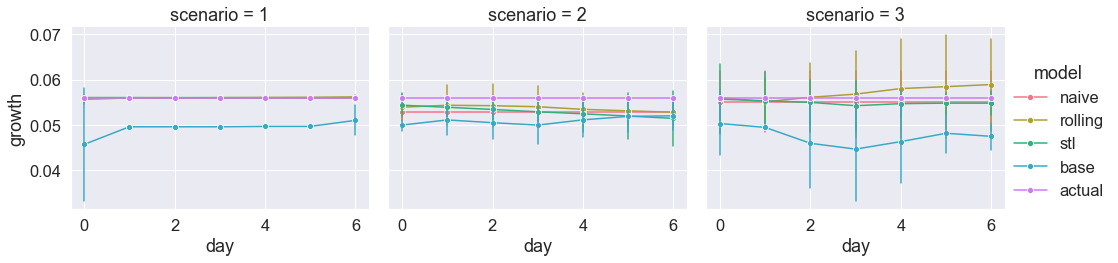

In [67]:
remove_growths.rename(columns={'index':'day'},inplace=True)

g = sns.FacetGrid(remove_growths, col="scenario", hue='model',sharey=True, sharex=False,
                 height=4, aspect=1.2,palette='husl')
g.map(sns.lineplot, "day", "growth", marker='o',err_style='bars',ci='sd')
g.add_legend()

In [16]:
noise_results=pd.read_pickle('simulation_data/noise_simulation_results')
remove_results=pd.read_pickle('simulation_data/removed_simulation_results')

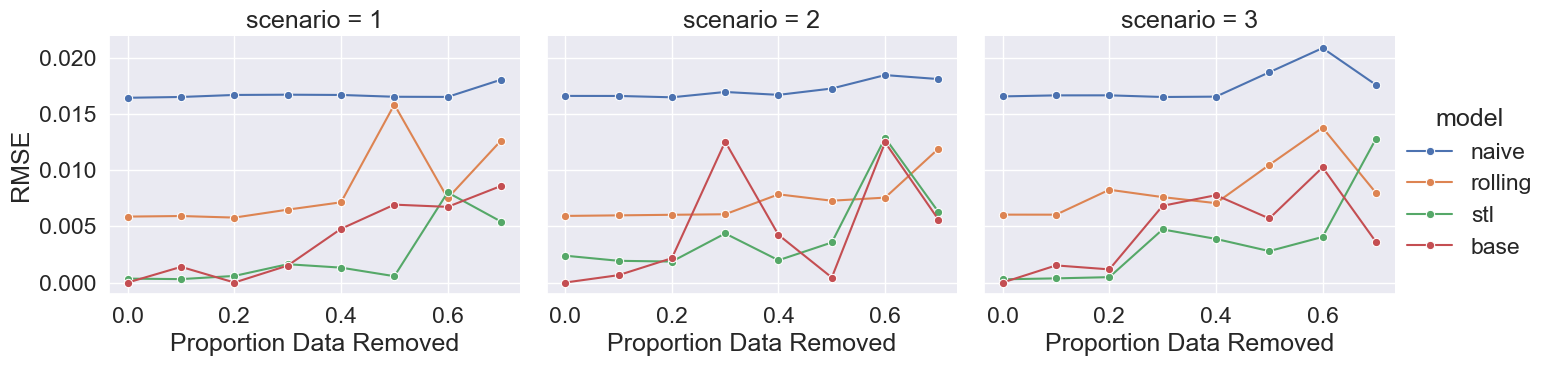

In [119]:
import seaborn as sns

# plot increasing removed
sns.set(font_scale=1.5)
g = sns.FacetGrid(moving_remove, col="scenario", hue='model',sharey=True, sharex=False,
                 height=4, aspect=1.2)
g.map(sns.lineplot, "data", "rmse", marker='o',err_style='bars',ci='sd')
g.add_legend()
g.set_axis_labels("Proportion Data Removed")
axes = g.axes.flatten()
axes[0].set_ylabel('RMSE')
# axes[0].set_xlabel('Proportion Data removedd')
plt.show()

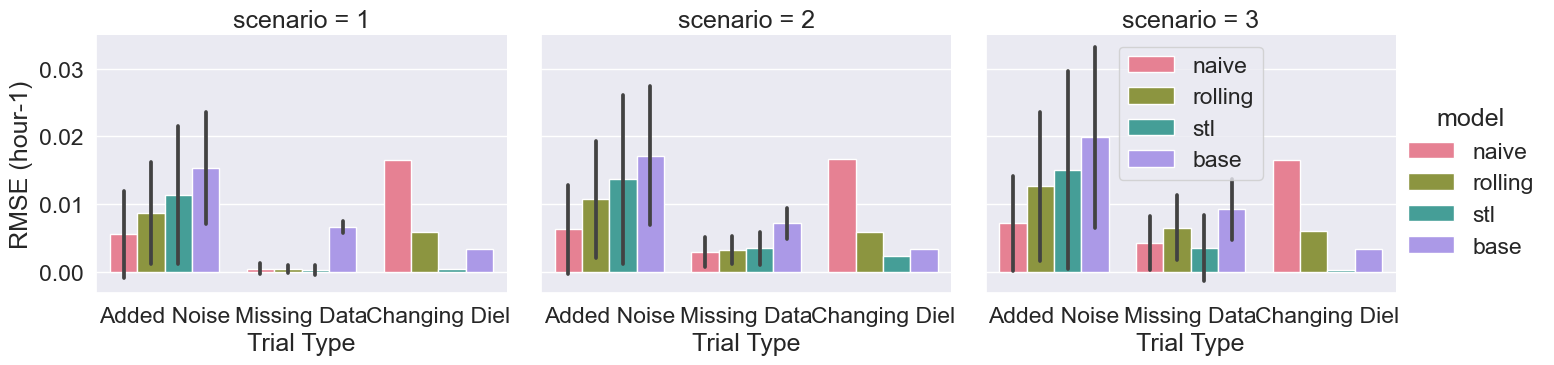

In [187]:
remove_rmse=remove_results[['rmse','scenario','model']]
remove_rmse['trial']='Missing Data'
noise_rmse=noise_results[['rmse','scenario','model']]
noise_rmse['trial']='Added Noise'
moving_rmse=moving_results[['rmse','scenario','model']]
moving_rmse['trial']='Changing Diel'
all_trials=pd.concat([noise_rmse, remove_rmse,moving_rmse])


sns.set(font_scale=1.8)
g = sns.catplot(data=all_trials, x='trial', y='rmse', hue='model', col='scenario', kind='bar',palette='husl',
               errorbar='sd',height=6)
plt.legend()
g.set_axis_labels("Trial Type",'RMSE (hour-1)')
plt.show()

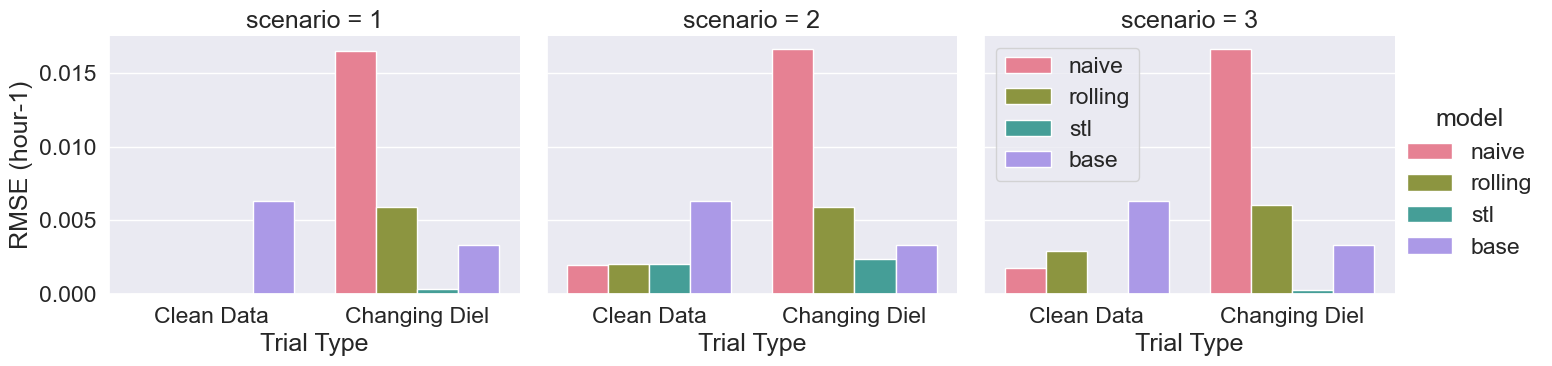

In [188]:
clean_results=pd.concat(result_dfs)
clean_results['trial']='Clean Data'
moving_results['trial']='Changing Diel'
# concatenate with moving results
scenario_trials=pd.concat([clean_results,moving_results])

sns.set(font_scale=1.5)
g = sns.catplot(data=scenario_trials, x='trial', y='rmse', hue='model', col='scenario', kind='bar',palette='husl',
               errorbar='sd',height=4, aspect=1.2)
plt.legend()
g.set_axis_labels("Trial Type",'RMSE (hour-1)')
plt.show()

In [22]:
## running entire model w/o bootstrapping or zinser data
def run_full_model(df, col, remove=0, noise=0, blocks=False, model='STL', show_plots=True):
    # first generate noise if prompted
    if noise > 0:
        # calculate std to sample from noise
        x=df[col]
        # set mean to 0 for gaussian noise
        mu=0
        std = noise * np.std(x) 
        # add noise to data
        df['data_with_noise']=gaussian_noise(x,mu,std)
    # don't generate noise    
    else:
        df['data_with_noise']=df[col]
    
    # generate missing data if prompted
    if remove > 0:
        # generate blocks of missing datam
        if blocks:
            # remove block length and amount of data to remove
            missing=generate_random_chunks(df,'data_with_noise',remove, missing_col='data_with_missing')
        else:
            # generate misisng data at random
            missing=generate_missing_data(df, 'data_with_noise', remove,missing_col='data_with_missing')
        # save missing data
        missing_data=missing['data_with_missing']
        # calculate imputed values
        impute_df=run_imputation(missing, 'data_with_noise', missing_col='data_with_missing',period=24, interval=1)
        # rename col
        impute_df.rename(columns={'with_missing':'data_with_missing'},inplace=True)
        # reset time of day columns
        impute_df['time_of_day']=df['time_of_day']
        # check if imputation ran
        if impute_df is None:
            print('Imputation Failed')
            return
    else: # run STL model on complete dataset (no missing values)
        # add necessary columns
        impute_df=df.copy()
        # replace with noise column (doesn't matter if noise was added or not)
        impute_df['with_missing']=impute_df['data_with_noise']
        # check if there are missing values, and replace with noise
        impute_df['data_with_missing']=np.where(impute_df['with_missing']>0, impute_df['with_missing'], 
         np.mean(impute_df['with_missing']))
        # save missing data
        missing_data=impute_df['data_with_missing']

    ## run STL model
    if model.lower().startswith('s'):
        # get tsd components
#         display(impute_df)
        tsd_df=run_STL(impute_df, col='data_with_missing',period=24)
        # calculate growth
        growth_df=calc_diel_growth(tsd_df, 'diel', model)
        growth_df['remove']=remove
        growth_df['noise']=noise
    ## run naive model
    elif model.lower().startswith('n'):
        # get tsd components
        tsd_df=run_naive(impute_df, col='data_with_missing',period=24)
        # save missing components 
        tsd_df['unfilled']=missing_data
        growth_df=calc_diel_growth(tsd_df, 'diel', model)
        growth_df['remove']=remove
        growth_df['noise']=noise
    ## run STL model
    elif model.lower().startswith('roll'):
        # get components from rolling model
        pro_seasonal, pro_trend, pro_resid = rolling_tsd(impute_df.set_index('hour'), 'data_with_missing', period=24,
                                                        window=3, type='log additive', extrapolate=True)
        pro_all=summarize_rolling(pro_seasonal, pro_trend, pro_resid)
        pro_all.rename(columns={'seasonal':'diel'}, inplace=True)
        # get other necessary columns`a
        tsd_df=pd.merge(pro_all, impute_df[['hour','time_of_day','data_with_missing']], on='hour')
        # calculate growth and productivity
        growth_df=calc_diel_growth(tsd_df, 'diel', model)
        growth_df['remove']=remove
        growth_df['noise']=noise
    ## run baseline model (just dusk+dawn, no decomposition)
    elif model.lower().startswith('base'):
        tsd_df=impute_df.copy()
        growth_df=calc_diel_growth(tsd_df, 'data_with_missing',model)
        growth_df['remove']=remove
        growth_df['noise']=noise
        
    else: 
        return('Choose a valid model: baseline, naive, rolling, or STL')
    return(tsd_df, growth_df)

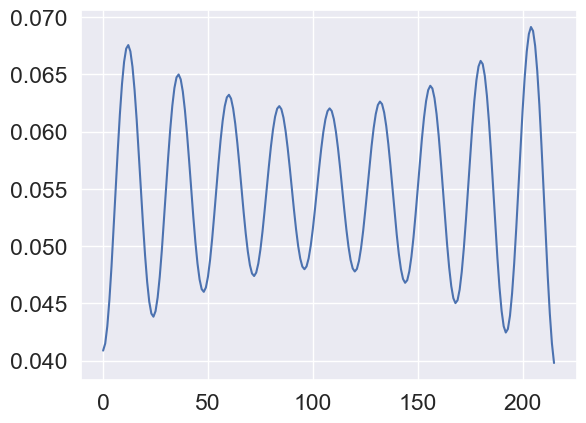

In [23]:
# generate simulation data with known periodicity of 24H, 10 full days
cycles = 10 # how many sine cycles
resolution = cycles*24 # how many datapoints to generate
# calculate length
length = np.pi * 2 * cycles
# set x with custom amplitude
x=np.arange(0, length, length / resolution)
# adjust amplitude and start/end
my_wave = np.sin(x)#*0.15 + 0.55
#am_wave=my_wave*(((x - len(x)/8) ** 2)+50)
am_wave=my_wave*(((x - length/2) ** 2)+700)/100000 + 0.055
start=np.where(my_wave == np.min(my_wave))[0][0]
end=np.where(my_wave == np.min(my_wave))[0][-1]-1
# crop wave
new_wave=am_wave[start:end+1]

plt.plot(new_wave)

In [24]:
noise_df1, growth_df=run_full_model(trial1_df, 'data1',model='naive', noise=0.5)
noise_df2, growth_df=run_full_model(trial1_df, 'data2',model='naive', noise=0.5)
noise_df3, growth_df=run_full_model(trial1_df, 'data3',model='naive', noise=0.5)

remove_df1, growth_df=run_full_model(trial1_df, 'data1',model='naive', remove=0.5)
remove_df2, growth_df=run_full_model(trial1_df, 'data2',model='naive', remove=0.5)
remove_df3, growth_df=run_full_model(trial1_df, 'data3',model='naive', remove=0.5)

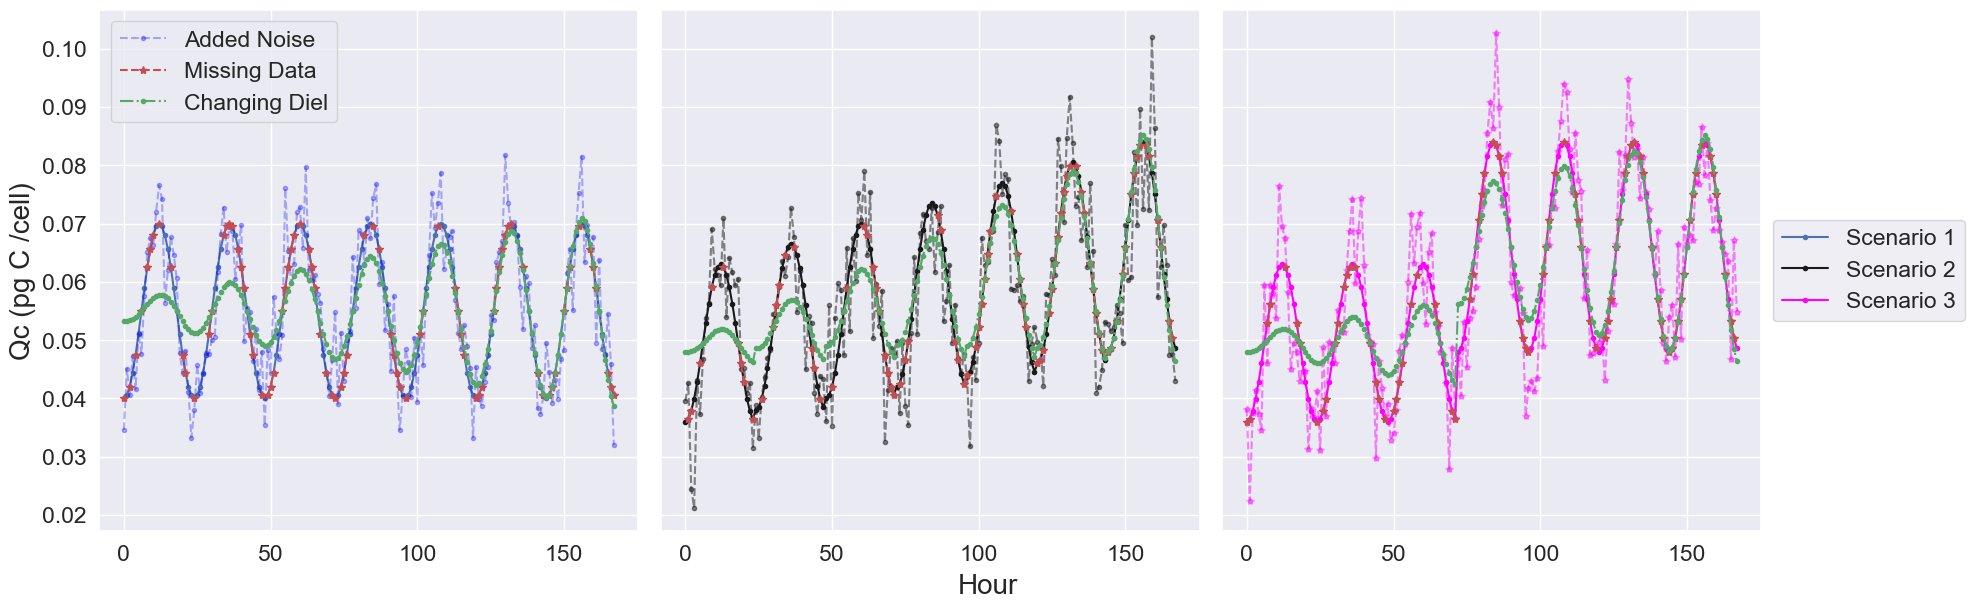

In [164]:
# show simulation data
fig,axs=plt.subplots(figsize=(20,6), ncols=3, sharey=True)
## plot scenario 1
ln1=axs[0].plot(new_wave, marker='.', label='Scenario 1')
# add noise and missing data 
d1=axs[0].plot(noise_df1['data_with_missing'], marker='.', c='blue',linestyle='--',alpha=0.3,label='Added Noise')
d2=axs[0].plot(remove_df1['unfilled'], marker='*', c='r',linestyle='--', label='Missing Data')
d3=axs[0].plot(sim_df['moving_data1'], marker='.', c='g',linestyle='-.', label='Changing Diel')
lns=d1+d2+d3
labs = [l.get_label() for l in lns]
axs[0].legend(lns,labs,loc='upper left')
axs[0].set_ylabel('Qc (pg C /cell)', size=20)

## plot scenario 2
ln2=axs[1].plot(data2, marker='.', c='k', label='Scenario 2')
axs[1].plot(noise_df2['data_with_missing'], marker='.', c='k',linestyle='--',alpha=0.3)
d1=axs[1].plot(noise_df2['data_with_missing'], marker='.', c='k',linestyle='--',alpha=0.3,label='Added Noise')
d2=axs[1].plot(remove_df2['unfilled'], marker='*', c='r',linestyle='--', label='Missing Data')
d3=axs[1].plot(sim_df['moving_data2'], marker='.', c='g',linestyle='-.', label='Changing Diel')


## plot scenario 3
ln3=axs[2].plot(breaks, marker='.', c='magenta', label='Scenario 3')
axs[2].plot(noise_df3['data_with_missing'], marker='*', c='magenta',linestyle='--',alpha=0.25)
d1=axs[2].plot(noise_df3['data_with_missing'], marker='.', c='magenta',
               linestyle='--',alpha=0.3,label='Added Noise')
d2=axs[2].plot(remove_df3['unfilled'], marker='*', c='r',linestyle='--', label='Missing Data')
d3=axs[2].plot(sim_df['moving_data3'], marker='.', c='g',linestyle='-.', label='Changing Diel')


fig.text(0.5, -0.01, 'Hour', ha='center', size=20)
plt.rcParams.update({'font.size':15})
lns=ln1+ln2+ln3
labs = [l.get_label() for l in lns]
axs[2].legend(lns,labs,loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()